#### 1. load the veteran dataset from R survival package
http://www-eio.upc.edu/~pau/cms/rdata/doc/survival/veteran.html
http://www-eio.upc.edu/~pau/cms/rdata/datasets.html

In [1]:
import pandas as pd

veteran_df = pd.read_csv('veteran.csv')
veteran_df.head()

,Unnamed: 0,trt,celltype,time,status,karno,diagtime,age,prior
0,1,1,squamous,72,1,60,7,69,0
1,2,1,squamous,411,1,70,5,64,10
2,3,1,squamous,228,1,60,3,38,0
3,4,1,squamous,126,1,60,9,63,10
4,5,1,squamous,118,1,70,11,65,10


### 2. Ues exponential function to model survival distribution -- A parametric approach

In [2]:
from lifelines import ExponentialFitter

veteran_df_1 = veteran_df[veteran_df.trt==1]

epf = ExponentialFitter().fit(veteran_df_1['time'], veteran_df_1['status'])
epf

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 69 total observations, 5 right-censored observations>

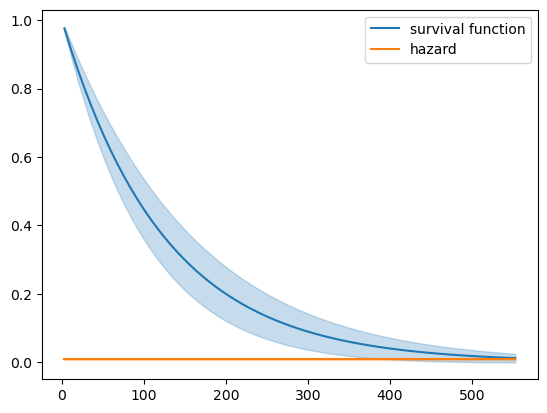

In [3]:
import matplotlib.pyplot as plt

epf.plot_survival_function(label='survival function').legend()
epf.plot_hazard(label='hazard').legend()

### 3. Predicting survival probability
Limited to univariate models, only time t is an independent variable.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(veteran_df_1)

print("Train:",train.shape,  "\nTest:", test.shape)

Train: (51, 9) 
Test: (18, 9)


In [5]:
## built the model using train dataset
train_epf = ExponentialFitter().fit(train['time'], train['status'])

In [6]:
## evaluate it with test dataset
estimated_sp = train_epf.predict(test['time'])

In [7]:
## estimated_sp contains all estimated survival probabilities.
estimated_sp

553    0.009068
82     0.497889
103    0.416456
27     0.794832
287    0.087089
117    0.369709
117    0.369709
16     0.872778
3      0.974809
216    0.159295
52     0.642596
21     0.836443
314    0.069221
25     0.808467
123    0.351317
132    0.325430
117    0.369709
117    0.369709
54     0.631758
59     0.605457
Name: Exponential_estimate, dtype: float64

### 4. Computing Accuracy -- Brier Score
Brier Score is like mean squared error of probabilities. A lower value indicates better result

In [8]:
import math

def brier_score(actual, estimated):
    n = len(actual)
    error = 0.0
    for i in range(n):
        error += math.pow(estimated.iloc[i] - actual.iloc[i], 2)
    return error/n


In [9]:
brier_score(test['status'], 1.0 - estimated_sp)

0.31054388795253035

### 5. Parameter Models
#### 1) Weibull distribution

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import weibull_min

shape = 5
scale = 0.001
weibull_samples = weibull_min.rvs(shape, 0, scale, size=1000)
weibull_samples

array([0.00072435, 0.00116061, 0.00093326, 0.00097501, 0.00065206,
       0.0010693 , 0.0007595 , 0.00142183, 0.00086223, 0.00105763,
       0.00061412, 0.00108123, 0.00091369, 0.00086994, 0.00107188,
       0.00095437, 0.00062916, 0.00098644, 0.00115589, 0.00097044,
       0.00117474, 0.00080623, 0.00117848, 0.00092341, 0.0008823 ,
       0.00119464, 0.00086856, 0.00110225, 0.00098207, 0.00065413,
       0.00071213, 0.00048401, 0.00094641, 0.0010083 , 0.00098964,
       0.00098646, 0.00077729, 0.00058465, 0.00081428, 0.00116019,
       0.00126945, 0.00067515, 0.00109014, 0.00116787, 0.00096807,
       0.00072326, 0.00092486, 0.00062994, 0.00100786, 0.0010844 ,
       0.00131078, 0.00076409, 0.00058146, 0.00076935, 0.00066644,
       0.00094181, 0.00093692, 0.00108654, 0.00066709, 0.00099122,
       0.00107441, 0.00095259, 0.00083328, 0.00054038, 0.00096438,
       0.00065104, 0.00106384, 0.0012544 , 0.00077342, 0.00090465,
       0.00038869, 0.00080891, 0.0010417 , 0.00072157, 0.00116

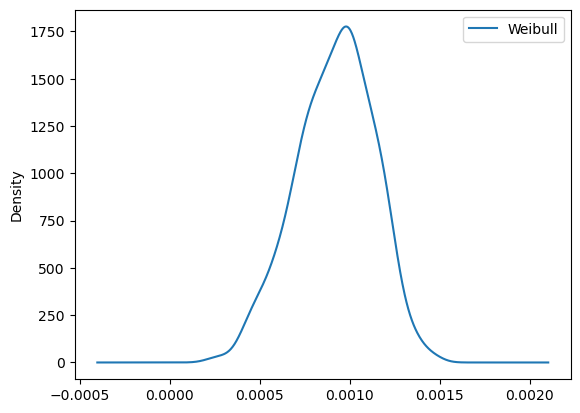

In [11]:
pd.DataFrame(weibull_samples).plot(kind='density')
plt.legend(['Weibull'])

In [12]:
import pandas as pd

stanford2_df = pd.read_csv("stanford2.csv")
stanford2_df.head()

,Unnamed: 0,id,time,status,age,t5
0,139,139,86.0,1,12,1.26
1,159,159,10.0,1,13,1.49
2,181,181,60.0,0,13,NaN
3,119,119,1116.0,0,14,0.54
4,74,74,2006.0,0,15,1.26


In [13]:
from sklearn.model_selection import train_test_split
from lifelines import WeibullFitter

train, test = train_test_split(stanford2_df)
wbf = WeibullFitter().fit(train['time'], train['status'])
wbf

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 138 total observations, 53 right-censored observations>

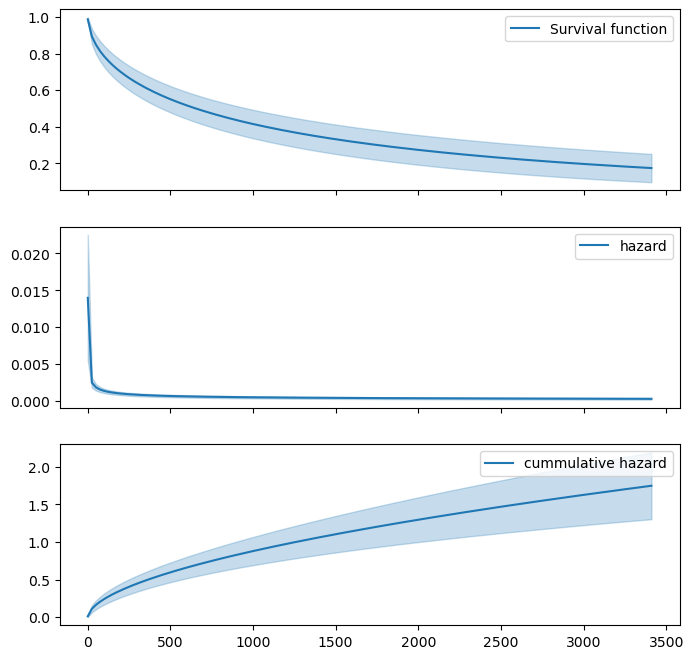

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(8, 8), sharex=True)
wbf.plot_survival_function(label='Survival function', ax = axs[0]).legend()
wbf.plot_hazard(label='hazard', ax=axs[1]).legend()
wbf.plot_cumulative_hazard(label='cummulative hazard', ax = axs[2]).legend()

In [15]:
# estimated parameters are k as rho, 1/p is lambda
wbf.lambda_, wbf.rho_

(1258.0276347561582, 0.5596841106282024)

In [16]:
# Brier Score
estimated_sp = wbf.predict(test['time'])
brier_score(test['status'], 1.0 - estimated_sp)

0.37639220686490527

#### CI for weibull
confidence intervals (CI)

In [17]:
import math

def cal_CI_Weibull(train, model, estimate_name):
    nu = len(train[train.status == 1])
    lower_col = estimate_name + '_lower'
    upper_col = estimate_name + '_upper'

    ci_limits = pd.DataFrame(columns=['time', lower_col, upper_col])
    z = 1.96
    for t_i in model.survival_function_.index:
        surv_prob = wbf.survival_function_.loc[t_i, estimate_name]
        ci_limit = {}
        ci_limit['time'] = t_i
        ci_limit[lower_col] = (math.exp(math.log(surv_prob) * math.exp(z/math.sqrt(nu))))
        ci_limit[upper_col] = (math.exp(math.log(surv_prob) * math.exp(-z/math.sqrt(nu))))
        ci_limits = ci_limits.append(ci_limit, ignore_index=True)

    return ci_limits

In [18]:
cal_CI_Weibull(train, wbf, 'Weibull_estimate').head()

C:\Users\yc27965\AppData\Local\Temp\ipykernel_13200\4177482356.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ci_limits = ci_limits.append(ci_limit, ignore_index=True)
C:\Users\yc27965\AppData\Local\Temp\ipykernel_13200\4177482356.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ci_limits = ci_limits.append(ci_limit, ignore_index=True)
C:\Users\yc27965\AppData\Local\Temp\ipykernel_13200\4177482356.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ci_limits = ci_limits.append(ci_limit, ignore_index=True)
C:\Users\yc27965\AppData\Local\Temp\ipykernel_13200\4177482356.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ci_lim

,time,Weibull_estimate_lower,Weibull_estimate_upper
0,0.500000,0.984666,0.989950
1,25.386861,0.870060,0.913033
2,50.273723,0.815438,0.875146
3,75.160584,0.774506,0.846177
4,100.047445,0.740899,0.821993


#### 2) Gumbel distribution
u is log-transformed time t.
It is a distribution of maximum number (or minimum) among set of samples of different distribution.
It follows the family pf *extreme value distribution*.


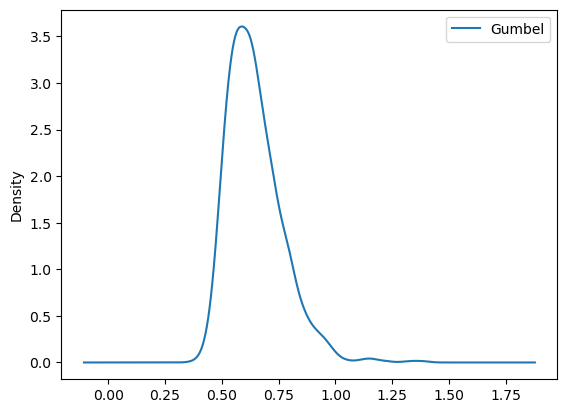

In [19]:
import numpy as np

k, rho = 0.6, 0.1
gumbel_samples = np.random.gumbel(k, rho, 1000)

pd.DataFrame(gumbel_samples).plot(kind='density')
plt.legend(['Gumbel'])

#### 3) Exponential distribution
Hazard is constant for exponential distribution.
It reflects the property of the distribution reasonably called *lack of memory*.
It is ideal for situations where events rate does not change over time.

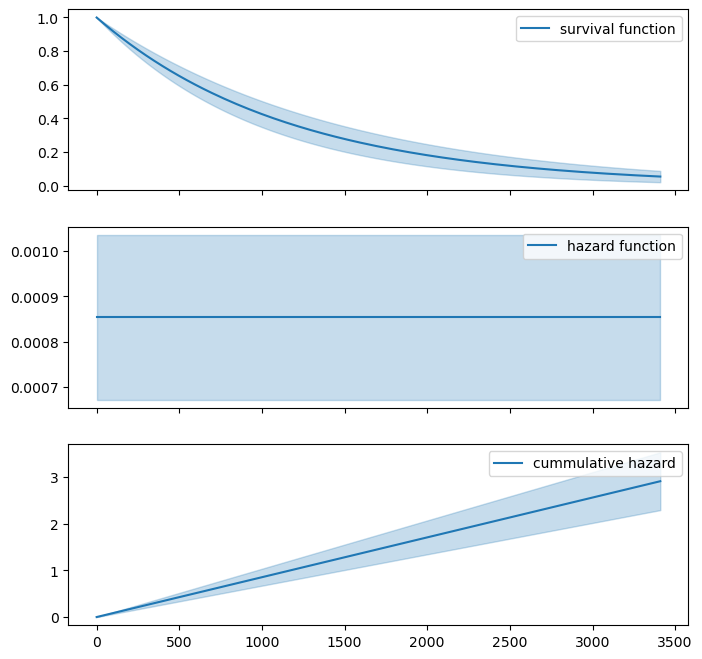

In [20]:
from lifelines import ExponentialFitter

exf = ExponentialFitter().fit(train['time'], train['status'])

fig, axs = plt.subplots(3, figsize=(8, 8), sharex=True)
exf.plot_survival_function(label='survival function', ax=axs[0]).legend()
exf.plot_hazard(label='hazard function', ax=axs[1]).legend()
exf.plot_cumulative_hazard(label='cummulative hazard', ax=axs[2]).legend()

In [21]:
# value of the distribution parameter : 1/p
exf.lambda_

1170.7117199207169

In [22]:
## comparison the model- AIC
wbf.AIC_, exf.AIC_

(1323.4666857136492, 1373.112422083575)

### 6.Non-paramter Model - Kaplan-Meier Estimator

In [23]:
import pandas as pd

stanford2_df = pd.read_csv('stanford2.csv')
stanford2_df.head()

,Unnamed: 0,id,time,status,age,t5
0,139,139,86.0,1,12,1.26
1,159,159,10.0,1,13,1.49
2,181,181,60.0,0,13,NaN
3,119,119,1116.0,0,14,0.54
4,74,74,2006.0,0,15,1.26


In [24]:
stanford2_df.shape

(184, 6)

In [25]:
stanford2_df_sorted = stanford2_df.sort_values(by=['time'])
event_counts = stanford2_df_sorted[stanford2_df_sorted['status']==1].groupby('time').size().reset_index(name='event/death')

In [26]:
event_counts

,time,event/death
0,0.5,1
1,1.0,2
2,3.0,1
3,5.0,1
4,7.0,1
...,...,...
93,1996.0,1
94,2127.0,1
95,2474.0,1
96,2723.0,1


<AxesSubplot:xlabel='time'>

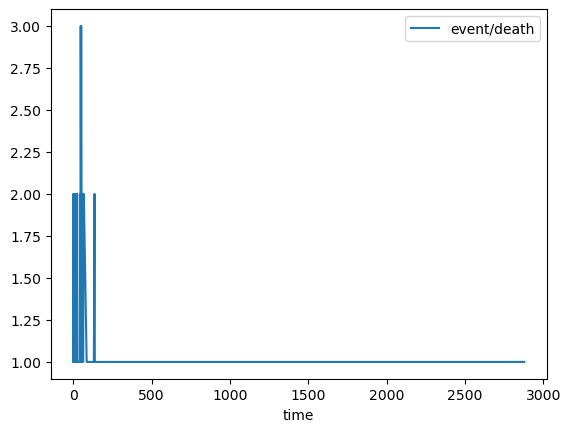

In [27]:
event_counts.plot(x='time', y='event/death')

In [28]:
stanford2_df_sorted

,Unnamed: 0,id,time,status,age,t5
71,21,21,0.5,1,41,0.87
171,16,16,1.0,1,54,0.47
22,184,184,1.0,0,27,NaN
15,133,133,1.0,1,21,0.47
60,183,183,2.0,0,39,NaN
...,...,...,...,...,...,...
141,25,25,2878.0,1,49,0.75
39,38,38,2984.0,0,32,0.19
59,36,36,3021.0,0,38,0.98
101,26,26,3410.0,0,45,0.98


In [29]:
# use lifelines library to model the KM estimator
from lifelines import KaplanMeierFitter

kmft = KaplanMeierFitter()
kmft.fit(stanford2_df_sorted['time'], stanford2_df_sorted['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 184 total observations, 71 right-censored observations>

<AxesSubplot:xlabel='timeline'>

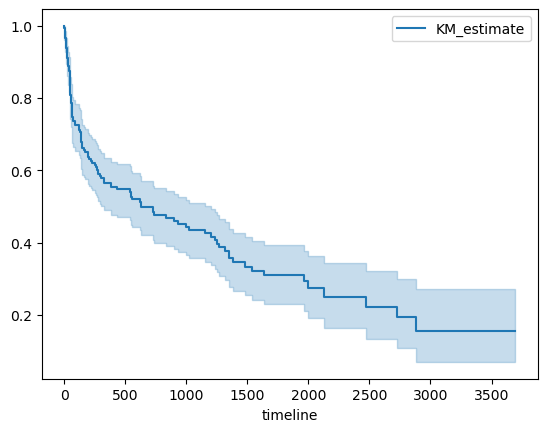

In [30]:
kmft.plot_survival_function()

#### computation of survival function for unknown time instance

In [31]:
pd.DataFrame(kmft.survival_function_at_times(times=[1.5, 2878.0, 3500.0]))

,KM_estimate
1.5,0.983696
2878.0,0.154919
3500.0,0.154919


#### Greenwood's estimator -- confidence intervals of the survival function
Fro Kaplan-Meier model, Greenwood's formular is used to compute confidence intervals

In [32]:
kmft.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
0.5,0.962052,0.999233
1.0,0.950307,0.994712
2.0,0.950307,0.994712
3.0,0.942962,0.991762
...,...,...
2878.0,0.069245,0.271866
2984.0,0.069245,0.271866
3021.0,0.069245,0.271866
3410.0,0.069245,0.271866


#### Log-Rank Test
For Kaplan-Meier curves, this test of equality is vital as we do not have any predefined distribution.
Log-rank test is a large sample chis-square test to compare tow or more KM curves.

In [33]:
veteran_df_1 = veteran_df[veteran_df.trt==1].drop(['trt','Unnamed: 0'], axis=1)
veteran_df_2 = veteran_df[veteran_df.trt==2].drop(['trt','Unnamed: 0'], axis=1)

In [34]:
from lifelines import KaplanMeierFitter

kmft_1 = KaplanMeierFitter()
kmft_1.fit(veteran_df_1['time'], veteran_df_1['status'], label="Group 1")

kmft_2 = KaplanMeierFitter()
kmft_2.fit(veteran_df_2['time'], veteran_df_2['status'], label="Group 2")

<lifelines.KaplanMeierFitter:"Group 2", fitted with 68 total observations, 4 right-censored observations>

<AxesSubplot:xlabel='timeline'>

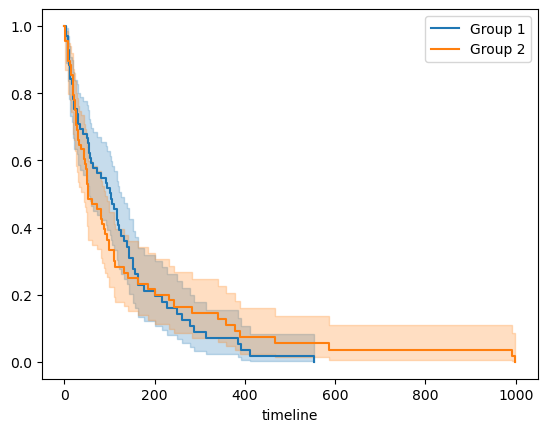

In [35]:
kmft_1.plot_survival_function()
kmft_2.plot_survival_function()

#### Mantel-Haenszel logrank test

In [36]:
veteran_df_sorted = veteran_df.sort_values(by=['time'])
veteran_df_sorted

,Unnamed: 0,trt,celltype,time,status,karno,diagtime,age,prior
76,77,2,squamous,1,1,20,21,65,10
84,85,2,squamous,1,1,50,7,35,0
94,95,2,smallcell,2,1,40,36,44,10
52,53,1,adeno,3,1,30,3,43,0
17,18,1,smallcell,4,1,40,2,35,0
...,...,...,...,...,...,...,...,...,...
82,83,2,squamous,467,1,90,2,64,0
57,58,1,large,553,1,70,2,47,0
77,78,2,squamous,587,1,60,3,58,0
74,75,2,squamous,991,1,70,7,50,10


In [37]:
n11 = len(veteran_df_1)
n21 = len(veteran_df_2)
n11, n21

(69, 68)

In [38]:
d11 = 0
d21 = 1

(n21 * (d11+d21))/ (n11 + n21)

0.49635036496350365

values of *$(LogRank)_i$* can be compared with $X^2$ table and corresponding *p*-value will decide acceptance or rejection of *$H_0$*

In [39]:
from lifelines.statistics import logrank_test

results = logrank_test(veteran_df_1['time'], veteran_df_2['time'],
                       veteran_df_1['status'], veteran_df_2['status'])

results.print_summary() ###???

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.93      0.11

In [40]:
logrank_test(veteran_df_1['time'], veteran_df_2['time'],veteran_df_1['status'], veteran_df_2['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.93      0.11

### 7.Model with Covariates
$$ $S_1$(t, \beta) = $S_0$(t$e^{\beta.x)}$ $$

$$ $h_1$(t, \beta) = $e^{\beta.x} $h_0$ (t$e^{\beta.x}$) $$

#### Accelerated Life Model(AFT)
*risk score* is zero is the *baseline survival* distribution.
$S_1$ and $S_0$, $h_1$ and $h_2$ must be from the same distribution family.


#### Weibull-AFT Model

In [41]:
veteran_df_1 = veteran_df[veteran_df.trt==1].drop(['trt','Unnamed: 0'], axis=1)
veteran_df_1.head()

,celltype,time,status,karno,diagtime,age,prior
0,squamous,72,1,60,7,69,0
1,squamous,411,1,70,5,64,10
2,squamous,228,1,60,3,38,0
3,squamous,126,1,60,9,63,10
4,squamous,118,1,70,11,65,10


In [42]:
veteran_df_1 = pd.get_dummies(veteran_df_1, columns=['celltype'])
veteran_df_1.head()

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
0,72,1,60,7,69,0,0,0,0,1
1,411,1,70,5,64,10,0,0,0,1
2,228,1,60,3,38,0,0,0,0,1
3,126,1,60,9,63,10,0,0,0,1
4,118,1,70,11,65,10,0,0,0,1


In [43]:
from lifelines import WeibullAFTFitter

waft = WeibullAFTFitter(fit_intercept=False).fit(veteran_df_1, duration_col='time', event_col='status')
waft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 69 total observations, 5 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 69
number of events observed = 64
           log-likelihood = -362.85
         time fit was run = 2023-03-01 05:20:56 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                  
lambda_ age                  0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
        celltype_adeno       2.41      11.16       0.99             0.47             4.36                 1.60                77.88
        celltype_large       3.64      38.01       0.96             1.76             5.52                 5.81               248.81
        celltype_smallcell   3.17      23.70       0.94             1.32             5.01                 3.76               149.29
        celltype_squamous    3.57      35.51       0.94             1.73             5.41                 5.65               223.15
        diagtime            -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
        karno                0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
        prior               -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
rho_    Intercept            0.08       1.08       0.09            -0.11             0.27                 0.90                 1.30

                             cmp to     z      p   -log2(p)
param   covariate                                          
lambda_ age                    0.00  0.19   0.85       0.24
        celltype_adeno         0.00  2.43   0.01       6.06
        celltype_large         0.00  3.80 <0.005      12.73
        celltype_smallcell     0.00  3.37 <0.005      10.38
        celltype_squamous      0.00  3.81 <0.005      12.79
        diagtime               0.00 -0.03   0.98       0.03
        karno                  0.00  3.05 <0.005       8.77
        prior                  0.00 -1.40   0.16       2.64
rho_    Intercept              0.00  0.85   0.40       1.33
---
Concordance = 0.69
AIC = 743.69
log-likelihood ratio test = 19.43 on 7 df
-log2(p) of ll-ratio test = 7.17

In [44]:
estimated_prob_weibull = waft.predict_survival_function(veteran_df_1, times=veteran_df_1['time'])
estimated_prob_weibull.head()

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
72.0,0.698056,0.648711,0.678640,0.565821,0.648564,0.329006,0.381687,0.808691,0.603313,0.760653,...,0.407520,0.813526,0.721699,0.774048,0.860058,0.859014,0.821678,0.810565,0.661153,0.568027
411.0,0.093206,0.057446,0.077370,0.023298,0.057360,0.000650,0.001732,0.246166,0.035584,0.164307,...,0.002669,0.256047,0.116129,0.184375,0.369646,0.366692,0.273466,0.249957,0.065122,0.023904
228.0,0.285586,0.221174,0.258837,0.137321,0.220999,0.020738,0.034806,0.476971,0.171744,0.385272,...,0.043734,0.486988,0.320753,0.409448,0.591203,0.588704,0.504214,0.480836,0.236319,0.139197
126.0,0.517305,0.452236,0.491228,0.351962,0.452048,0.130230,0.170998,0.677492,0.395903,0.605531,...,0.192816,0.684938,0.549886,0.625227,0.758483,0.756795,0.697576,0.680374,0.468268,0.354483
118.0,0.541234,0.477539,0.515778,0.378101,0.477354,0.149778,0.193024,0.695833,0.421887,0.626733,...,0.215867,0.702953,0.572916,0.645699,0.773005,0.771402,0.715026,0.698589,0.493287,0.380623


In [45]:
estimated_prob_weibull_T = estimated_prob_weibull.T
estimated_prob_weibull_T.head()

,72.0,411.0,228.0,126.0,118.0,10.0,82.0,110.0,314.0,100.0,...,12.0,260.0,200.0,156.0,182.0,143.0,105.0,103.0,250.0,100.0
0,0.698056,0.093206,0.285586,0.517305,0.541234,0.958542,0.661101,0.566125,0.169885,0.598624,...,0.949719,0.235781,0.337107,0.435730,0.374660,0.469543,0.582180,0.588711,0.250388,0.598624
1,0.648711,0.057446,0.221174,0.452236,0.477539,0.950300,0.607591,0.504102,0.118343,0.539144,...,0.939779,0.175603,0.270057,0.367820,0.306676,0.402451,0.521364,0.528413,0.188782,0.539144
2,0.678640,0.077370,0.258837,0.491228,0.515778,0.955363,0.639976,0.541406,0.147823,0.574999,...,0.945882,0.210508,0.309535,0.408231,0.346880,0.442498,0.557983,0.564736,0.224606,0.574999
3,0.565821,0.023298,0.137321,0.351962,0.378101,0.935120,0.519105,0.406018,0.060305,0.443559,...,0.921520,0.101363,0.178589,0.268177,0.211117,0.301886,0.424411,0.431978,0.111491,0.443559
4,0.648564,0.057360,0.220999,0.452048,0.477354,0.950275,0.607433,0.503922,0.118211,0.538970,...,0.939749,0.175443,0.269872,0.367628,0.306487,0.402260,0.521186,0.528237,0.188618,0.538970


In [46]:
estimated_prob_weibull_T = estimated_prob_weibull_T.reset_index(drop=True)
estimated_prob_weibull_T.head()

,72.0,411.0,228.0,126.0,118.0,10.0,82.0,110.0,314.0,100.0,...,12.0,260.0,200.0,156.0,182.0,143.0,105.0,103.0,250.0,100.0
0,0.698056,0.093206,0.285586,0.517305,0.541234,0.958542,0.661101,0.566125,0.169885,0.598624,...,0.949719,0.235781,0.337107,0.435730,0.374660,0.469543,0.582180,0.588711,0.250388,0.598624
1,0.648711,0.057446,0.221174,0.452236,0.477539,0.950300,0.607591,0.504102,0.118343,0.539144,...,0.939779,0.175603,0.270057,0.367820,0.306676,0.402451,0.521364,0.528413,0.188782,0.539144
2,0.678640,0.077370,0.258837,0.491228,0.515778,0.955363,0.639976,0.541406,0.147823,0.574999,...,0.945882,0.210508,0.309535,0.408231,0.346880,0.442498,0.557983,0.564736,0.224606,0.574999
3,0.565821,0.023298,0.137321,0.351962,0.378101,0.935120,0.519105,0.406018,0.060305,0.443559,...,0.921520,0.101363,0.178589,0.268177,0.211117,0.301886,0.424411,0.431978,0.111491,0.443559
4,0.648564,0.057360,0.220999,0.452048,0.477354,0.950275,0.607433,0.503922,0.118211,0.538970,...,0.939749,0.175443,0.269872,0.367628,0.306487,0.402260,0.521186,0.528237,0.188618,0.538970


In [47]:
import math
import numpy as np

def brier_score(actual, estimated):
    n = len(actual)
    total_error = 0.0
    for i in range(n):
        actual_prob = actual['status'].iloc[i]
        
        estimated_prob = estimated.iloc[i][actual.iloc[i]['time']]
        
        if isinstance(estimated_prob, np.float64):
            error = (1.0 - estimated_prob) - actual_prob
        else:
            error = (1.0 - estimated_prob.iloc[0]) - actual_prob
        total_error += (error * error)
    
    return total_error/n

In [48]:
brier_score(veteran_df_1, estimated_prob_weibull_T)

0.3506369133933205

#### plotting baseline vs Orignial Survival Function

In [49]:
import numpy as np

def compute_baseline_survival_function(df, model, times=None):
    covariates = list(df[df.columns.difference(['time', 'status'])])
    
    X = pd.DataFrame(np.zeros(shape=(1, len(covariates))), columns=covariates)
    return model.predict_survival_function(X, times=times)

In [50]:
veteran_df_1.iloc[10:11]

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
10,42,1,60,4,81,0,0,0,0,1


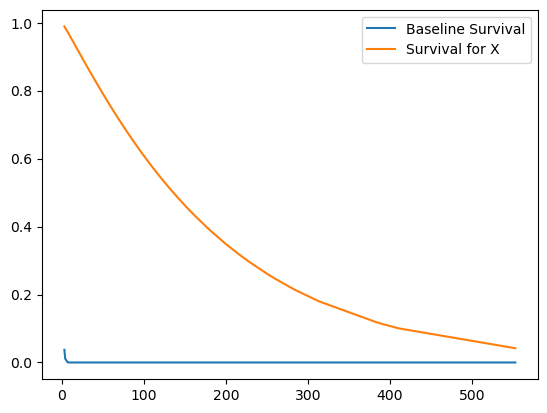

In [51]:
import matplotlib.pyplot as plt

plt.plot(compute_baseline_survival_function(veteran_df_1, waft))
plt.plot(waft.predict_survival_function(veteran_df_1.iloc[10:11]))
plt.legend(["Baseline Survival", "Survival for X"])

#### Stepwise computation of relation $ S_1 (t, \beta) = S_0 (te^{\beta . x}) $

In [52]:
veteran_df_1.iloc[59:60]

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
59,12,1,40,12,68,10,0,1,0,0


In [53]:
def compute_risk_score(covariates, w):
    risk_score = 0.0
    for e in list(covariates):
        risk_score += (w[('lambda_', e)] * list(covariates[e].values())[0])
    
    return risk_score

In [54]:
weights = waft.params_.to_dict()
weights

# reson for w[('lambda_', e)] due to we can get weights from summary

{('lambda_', 'age'): 0.002309282274022271,
 ('lambda_', 'celltype_adeno'): 2.412369978608433,
 ('lambda_', 'celltype_large'): 3.637943481764507,
 ('lambda_', 'celltype_smallcell'): 3.1653539966461226,
 ('lambda_', 'celltype_squamous'): 3.5697115345660704,
 ('lambda_', 'diagtime'): -0.0004652078957940598,
 ('lambda_', 'karno'): 0.02492040580518137,
 ('lambda_', 'prior'): -0.04099003976289929,
 ('rho_', 'Intercept'): 0.0801526401495805}

In [55]:
import math

x = veteran_df_1[veteran_df_1.columns.difference(['time', 'status'])].iloc[59:60].to_dict()
x

{'age': {59: 68},
 'celltype_adeno': {59: 0},
 'celltype_large': {59: 1},
 'celltype_smallcell': {59: 0},
 'celltype_squamous': {59: 0},
 'diagtime': {59: 12},
 'karno': {59: 40},
 'prior': {59: 10}}

In [56]:
t = 333.0
si = math.exp(compute_risk_score(x, weights))
si

79.54381613815268

In [57]:
compute_baseline_survival_function(veteran_df_1, model=waft, times=[t*si])

,0
26488.090774,0.0


In [58]:
compute_baseline_survival_function(veteran_df_1, model=waft, times=[t])

,0
333.0,1.518146e-235


#### Proportional Hazard Model

Hazard ratio is used to compare risks between two subjects.
HR > 1 indicated i has more hazard rate than j.

##### Cox-PH Model -- semi-parametric model
Cox (1972) proposed Cox-PH model with no assumption on $h_0$(t).

Baseline hazard and parameter estimations are done using a technique called *Breslow's* method.

In [59]:
from lifelines import CoxPHFitter

cxphft = CoxPHFitter(penalizer=0.01).fit(veteran_df_1, duration_col='time', event_col='status')
cxphft.print_summary()

<lifelines.CoxPHFitter: fitted with 69 total observations, 5 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 69
number of events observed = 64
   partial log-likelihood = -200.27
         time fit was run = 2023-03-01 05:20:56 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
karno               -0.02       0.98       0.01            -0.04            -0.01                 0.96                 0.99
diagtime             0.01       1.01       0.02            -0.03             0.04                 0.97                 1.05
age                 -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
prior                0.04       1.04       0.03            -0.03             0.10                 0.97                 1.10
celltype_adeno       0.90       2.45       1.47            -1.98             3.77                 0.14                43.44
celltype_large      -0.46       0.63       1.45            -3.30             2.39                 0.04                10.88
celltype_smallcell   0.12       1.12       1.44            -2.71             2.94                 0.07                18.92
celltype_squamous   -0.31       0.73       1.45            -3.15             2.53                 0.04                12.56

                     cmp to     z    p   -log2(p)
covariate                                        
karno                  0.00 -2.76 0.01       7.45
diagtime               0.00  0.26 0.80       0.33
age                    0.00 -0.28 0.78       0.36
prior                  0.00  1.15 0.25       1.99
celltype_adeno         0.00  0.61 0.54       0.88
celltype_large         0.00 -0.31 0.75       0.41
celltype_smallcell     0.00  0.08 0.93       0.10
celltype_squamous      0.00 -0.21 0.83       0.27
---
Concordance = 0.70
Partial AIC = 416.55
log-likelihood ratio test = 18.26 on 8 df
-log2(p) of ll-ratio test = 5.69

In [60]:
estimated_prob_coxph = cxphft.predict_survival_function(veteran_df_1, times=veteran_df_1['time'])
estimated_prob_coxph

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
72.0,0.700378,0.668826,0.676621,0.589937,0.661480,0.360533,0.426867,0.783567,0.588302,0.759085,...,0.473806,0.816309,0.736151,0.788896,0.863570,0.858675,0.823760,0.812039,0.692175,0.599022
411.0,0.066970,0.047197,0.051536,0.018203,0.043401,0.000433,0.001561,0.157003,0.017823,0.123383,...,0.003447,0.214224,0.097749,0.165293,0.328412,0.314542,0.229521,0.205863,0.061241,0.020442
228.0,0.280214,0.237672,0.247716,0.151797,0.228478,0.026140,0.047788,0.418423,0.150300,0.373567,...,0.069370,0.484310,0.334791,0.428678,0.592160,0.580257,0.500287,0.475322,0.268667,0.160315
126.0,0.525327,0.483331,0.493560,0.385229,0.473778,0.158181,0.214652,0.643483,0.383302,0.607601,...,0.259197,0.692903,0.574825,0.651415,0.767104,0.759262,0.704377,0.686366,0.514259,0.396019
118.0,0.556932,0.516298,0.526224,0.420065,0.507011,0.186997,0.246821,0.669751,0.418154,0.635705,...,0.292985,0.716361,0.604447,0.677253,0.785785,0.778479,0.727139,0.710214,0.546252,0.430750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143.0,0.474028,0.430371,0.440951,0.330819,0.420522,0.117848,0.167905,0.599757,0.328900,0.561150,...,0.208945,0.653492,0.526201,0.608339,0.735316,0.726607,0.666057,0.646348,0.462466,0.341588
105.0,0.615705,0.578244,0.587440,0.487397,0.569612,0.249256,0.313712,0.717386,0.485558,0.687035,...,0.361603,0.758513,0.658923,0.724038,0.818935,0.812621,0.767957,0.753116,0.605907,0.497646
103.0,0.630615,0.594084,0.603062,0.504988,0.585650,0.266940,0.332178,0.729238,0.503177,0.699877,...,0.380213,0.768928,0.672625,0.735665,0.827046,0.820982,0.778026,0.763725,0.621071,0.515079
250.0,0.258645,0.217114,0.226880,0.134808,0.208198,0.020780,0.039461,0.396088,0.133395,0.351111,...,0.058642,0.462699,0.312502,0.406415,0.572943,0.560710,0.478941,0.453577,0.247330,0.142862


In [63]:
estimated_prob_coxph_T = estimated_prob_coxph.T
estimated_prob_coxph_T = estimated_prob_coxph_T.reset_index(drop=True)
brier_score(veteran_df_1, estimated_prob_coxph_T)

0.3343834526503375

In [64]:
#### Plottitng baselines vs Original Hazard Function
weights = cxphft.params_.to_dict()
weights

{'karno': -0.024744311037712994,
 'diagtime': 0.005121897690747877,
 'age': -0.003644287479534897,
 'prior': 0.03611805343659991,
 'celltype_adeno': 0.8951215608501689,
 'celltype_large': -0.4555784905818235,
 'celltype_smallcell': 0.11754330180426108,
 'celltype_squamous': -0.310953985924497}

In [65]:
def compute_risk_score(covariates, w):
    risk_score = 0.0
    for e in list(covariates):
        risk_score += (w[e] * list(covariates[e].values())[0])
    
    return risk_score

In [71]:
import math

## function to compute hazard for cox-PH model for given covairates
def compute_hazard_function(model, x, weights):
    si = math.exp(compute_risk_score(x, weights))
    
    return si * model.baseline_hazard_


In [67]:
x = veteran_df_1[veteran_df_1.columns.difference(['time', 'status'])].iloc[59:60].to_dict()
x

{'age': {59: 68},
 'celltype_adeno': {59: 0},
 'celltype_large': {59: 1},
 'celltype_smallcell': {59: 0},
 'celltype_squamous': {59: 0},
 'diagtime': {59: 12},
 'karno': {59: 40},
 'prior': {59: 10}}

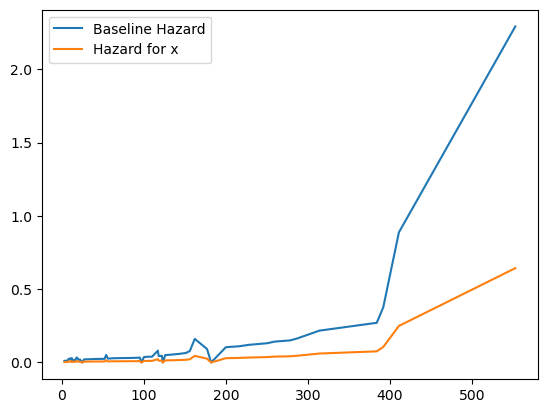

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cxphft.baseline_hazard_)
plt.plot(compute_hazard_function(cxphft, x, weights))
plt.legend(["Baseline Hazard", "Hazard for x"])

#### computing Hazard Ratio for two record

In [73]:
veteran_df_1.iloc[59:61]

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
59,12,1,40,12,68,10,0,1,0,0
60,260,1,80,5,45,0,0,1,0,0


In [74]:
## build a function computing hazard ratio
def compute_hazard_ratio(x1, x2, w):
    risk_score_x1 = compute_risk_score(x1, w)
    risk_score_x2 = compute_risk_score(x2, w)
    
    return math.exp(risk_score_x1)/math.exp(risk_score_x2)

In [75]:
x59 = veteran_df_1[veteran_df_1.columns.difference(['time', 'status'])].iloc[59:60].to_dict()
x60 = veteran_df_1[veteran_df_1.columns.difference(['time', 'status'])].iloc[60:61].to_dict()

compute_hazard_ratio(x59, x60, weights)

3.680275625760007

#### Weibull-Cox Model

Weibull and exponential are the only distribution that follows both AFT and PH model.


#### Wald Test
It tests whether weight of any covariate is zero or not. A zero weight indicates that the covariate is not at all important and has no contribution in score function.

It is done by Z-test.


#### Likelihood Ratio Test
It test that if we set any covariate weight to zero then does that changes the overall likelihood significantly or not?
Test statistic of *likelihood ratio test* for a covariate $\beta$ is given by
$$ LR_\beta = 2[L(\beta = \hat{\beta}) -  L(\beta=0)]$$

A bigger value of $LR_\beta$ indicateds more significance for the covariate.

As $LR_\beta$ follow a $X^2$ distribution with 1 degree of freedom, the null hypothesis can be accepted or rejected depending on th *p*-value.

#### Forward Selection Algorithm

In [114]:
def build_optimal_model_forward_selection(df, time_column, event_column, threshold_p_value):
    current_covariates = []
    global_set_covariates = list(df[df.columns.difference([time_column, event_column])])
    optimal_model = None
    
    while True:
        # Get next best covariate by runing a combination of models
        best_covariate, min_p_value, current_optimal_model = _get_next_best_covariate_(X=df,time_column= time_column,
                                                                                       event_column=event_column,
                                                                                       current_covariates=current_covariates,
                                                                                       remaining_covariates=global_set_covariates)
        
        # Add to the current set of covariates and remove global set
        current_covariates.append(best_covariate)
        global_set_covariates.remove(best_covariate)
        optimal_model = current_optimal_model
        
        if min_p_value <- threshold_p_value or len(global_set_covariates) <= 0:
            break
    
    return optimal_model

In [115]:
import sys

def _get_next_best_covariate_(X, time_column, event_column, current_covariates=None, remaining_covariates=None):
    min_p_value = sys.float_info.max
    best_covariate = None
    min_p_model = None
    
    #Iterate over the set and fit a model with additional covariate
    for covariate in remaining_covariates:
        covariates = []
        covariates.extend(current_covariates)
        covariates.append(covariate)
        covariates.append(time_column)
        covariates.append(event_column)
        
        model = CoxPHFitter(penalizer=0.01).fit(X[covariates], duration_col=time_column, event_col=event_column)
        
        current_p_value = model.log_likelihood_ratio_test().p_value
        
        # Find minimun of the p-value
        if min_p_value > current_p_value:
            best_covariate = covariate
            min_p_value = current_p_value
            min_p_model = model
    
    return best_covariate, min_p_value, min_p_model

In [116]:
optimal_model = build_optimal_model_forward_selection(df=veteran_df_1, time_column='time', event_column='status', threshold_p_value=0.00189)
optimal_model.print_summary()

<lifelines.CoxPHFitter: fitted with 69 total observations, 5 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 69
number of events observed = 64
   partial log-likelihood = -200.27
         time fit was run = 2023-03-01 06:11:23 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
karno               -0.02       0.98       0.01            -0.04            -0.01                 0.96                 0.99
celltype_adeno       0.90       2.45       1.47            -1.98             3.77                 0.14                43.44
celltype_smallcell   0.12       1.12       1.44            -2.71             2.94                 0.07                18.92
prior                0.04       1.04       0.03            -0.03             0.10                 0.97                 1.10
celltype_large      -0.46       0.63       1.45            -3.30             2.39                 0.04                10.88
age                 -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
diagtime             0.01       1.01       0.02            -0.03             0.04                 0.97                 1.05
celltype_squamous   -0.31       0.73       1.45            -3.15             2.53                 0.04                12.56

                     cmp to     z    p   -log2(p)
covariate                                        
karno                  0.00 -2.76 0.01       7.45
celltype_adeno         0.00  0.61 0.54       0.88
celltype_smallcell     0.00  0.08 0.93       0.10
prior                  0.00  1.15 0.25       1.99
celltype_large         0.00 -0.31 0.75       0.41
age                    0.00 -0.28 0.78       0.36
diagtime               0.00  0.26 0.80       0.33
celltype_squamous      0.00 -0.21 0.83       0.27
---
Concordance = 0.70
Partial AIC = 416.55
log-likelihood ratio test = 18.26 on 8 df
-log2(p) of ll-ratio test = 5.69

In [98]:
veteran_df_1

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
0,72,1,60,7,69,0,0,0,0,1
1,411,1,70,5,64,10,0,0,0,1
2,228,1,60,3,38,0,0,0,0,1
3,126,1,60,9,63,10,0,0,0,1
4,118,1,70,11,65,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
64,143,1,90,8,60,0,0,1,0,0
65,105,1,80,11,66,0,0,1,0,0
66,103,1,80,5,38,0,0,1,0,0
67,250,1,70,8,53,10,0,1,0,0
